In [101]:
# Autor:        Asier Ortiz García
# Kaggle:       https://www.kaggle.com/code/asierortiz/brain-mri-tumor-detection-model-benchmark
# GitHub:       https://github.com/asier-ortiz/ai-course-notebooks/blob/main/actividad6_asier_ortiz.ipynb
# nbviewer:     https://nbviewer.org/github/asier-ortiz/ai-course-notebooks/blob/main/actividad6_asier_ortiz.ipynb

# Brain MRI Tumor Detection - Model Benchmark

En el siguiente ejercicio se aplican técnicas de *Deep Learning* y *Transfer Learning* para detectar tumores cerebrales en imágenes MRI. Se comparan los modelos **VGG16**, **ResNet50** y **MobileNetV2**, utilizando **data augmentation** y un preprocesamiento basado en el **recorte de la región cerebral** de las imágenes.

## 1 - Instalación de dependencias

In [102]:
from IPython.display import clear_output
!pip install imutils
clear_output()

## 2 - Importaciones y configuración

In [103]:
import itertools
import os
import shutil
import warnings

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input as resnet_preprocess
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input as vgg_preprocess
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

import imutils

In [104]:
warnings.filterwarnings("ignore", category=UserWarning, module='keras.src.trainers.data_adapters.py_dataset_adapter')

In [105]:
# Ref. https://www.kaggle.com/docs/tpu
# Ref. https://www.kaggle.com/code/ryanholbrook/tpu-example
# Ref. https://www.kaggle.com/code/ryanholbrook/getting-started-with-tpus

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print("TPU disponible")
except ValueError:
    strategy = tf.distribute.get_strategy()
    print("TPU no disponible, usando CPU/GPU")

print("Número de réplicas:", strategy.num_replicas_in_sync)

TPU no disponible, usando CPU/GPU
Número de réplicas: 1


In [106]:
# Constantes
RANDOM_SEED = 123
IMG_SIZE = (224, 224)
EPOCHS = 100
BATCH_SIZE = 32
VAL_BATCH_SIZE = 16

# Variables globales auxiliares
model_accuracies = []

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

## 3 - Preparación de datos

### 3.1 Estructura de carpetas

In [107]:
# Limpieza del entorno por si ya existen carpetas de ejecuciones anteriores
!rm -rf TRAIN TEST VAL TRAIN_CROP TEST_CROP VAL_CROP

In [108]:
!mkdir -p TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!apt-get install tree > /dev/null
clear_output()
!tree -d

.
├── TEST
│   ├── NO
│   └── YES
├── TRAIN
│   ├── NO
│   └── YES
└── VAL
    ├── NO
    └── YES

9 directories


### 3.2 - División del dataset original en TRAIN / VAL / TEST

In [109]:
IMG_PATH = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/'

for CLASS in os.listdir(IMG_PATH):
    if (os.path.isfile(CLASS) == False) and (CLASS == "yes" or CLASS == "no"):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for n, FILE_NAME in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 5:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n < 0.8 * IMG_NUM:
                shutil.copy(img, 'TRAIN/' + CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'VAL/' + CLASS.upper() + '/' + FILE_NAME)

### 3.3 - Función auxiliar para la carga datos

In [110]:
def load_data(dir_path):
    X = []
    y = []
    i = 0
    labels = dict()

    for path in sorted(os.listdir(dir_path)):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1

    return np.array(X, dtype=object), np.array(y), labels

### 3.4 - Función auxiliar para la visualización de muestras

In [111]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Muestra una galería de 'n' imágenes del conjunto indicado
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n / j)

        plt.figure(figsize=(15, 6))
        c = 1
        for img in imgs:
            plt.subplot(i, j, c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

### 3.5 - Carga de imágenes y visualización de muestras

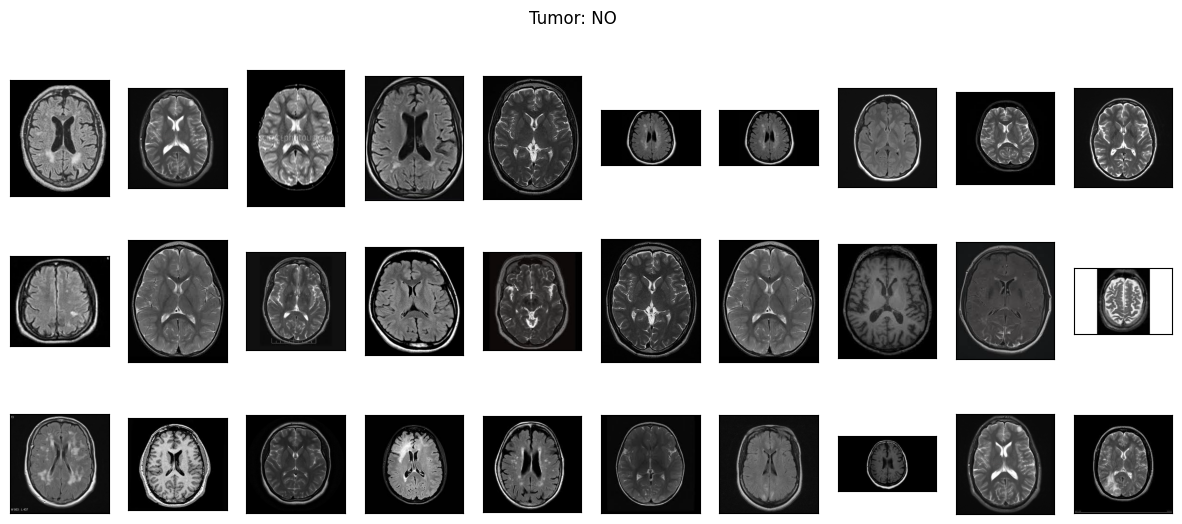

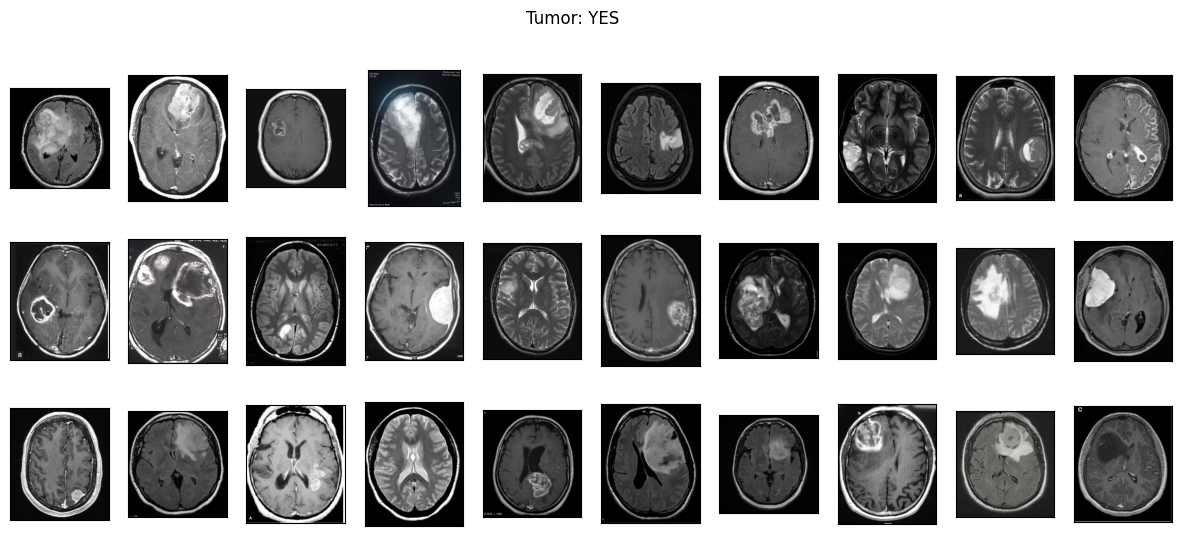

In [112]:
X_train, y_train, labels = load_data("TRAIN/")
X_val, y_val, _ = load_data("VAL/")
X_test, y_test, _ = load_data("TEST/")

plot_samples(X_train, y_train, labels, 30)

## 4 - Preprocesamiento de imágenes

### 4.1 - Función auxiliar para aplicar el recorte de la región cerebral

In [113]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Recorta la región cerebral de cada imagen en un conjunto
    """
    set_new = []

    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])
        new_img = img[extTop[1]:extBot[1], extLeft[0]:extRight[0]].copy()
        set_new.append(new_img)

    return np.array(set_new, dtype=object)

### 4.2 - Aplicar recorte y visualizar las muestras

In [114]:
X_train_crop = crop_imgs(X_train)
X_val_crop = crop_imgs(X_val)
X_test_crop = crop_imgs(X_test)


def plot_samples_class(X, y, labels, target_class, num_samples=15):
    """
    Visualiza una muestra de imágenes pertenecientes a una clase (con o sin tumor)
    """
    plt.figure(figsize=(15, 3))
    count = 0
    for i in range(len(X)):
        if y[i] == target_class:
            plt.subplot(1, num_samples, count + 1)
            plt.imshow(cv2.cvtColor(X[i], cv2.COLOR_BGR2RGB))
            plt.axis('off')
            count += 1
            if count == num_samples:
                break
    plt.suptitle(f"Tumor: {labels[target_class]}")
    plt.tight_layout()
    plt.show()

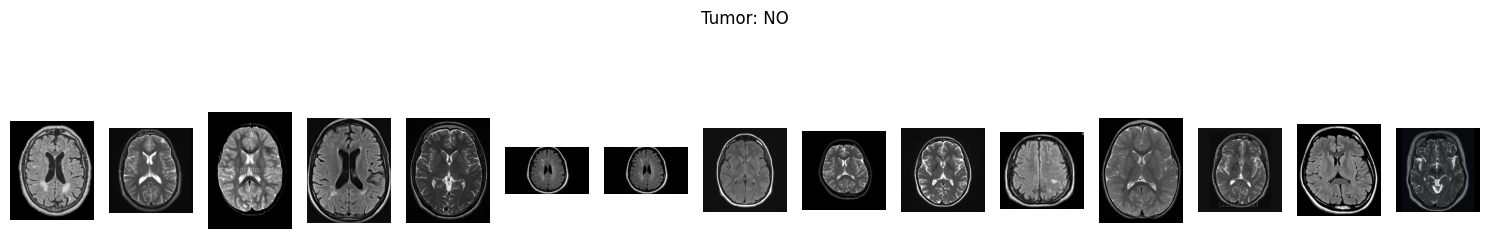

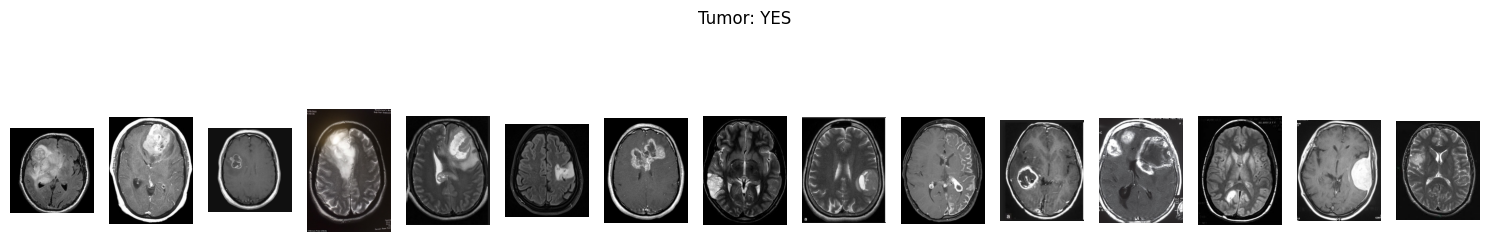

In [115]:
# Visualización antes del recorte
plot_samples_class(X_train, y_train, labels, 0)  # Clase NO
plot_samples_class(X_train, y_train, labels, 1)  # Clase YES

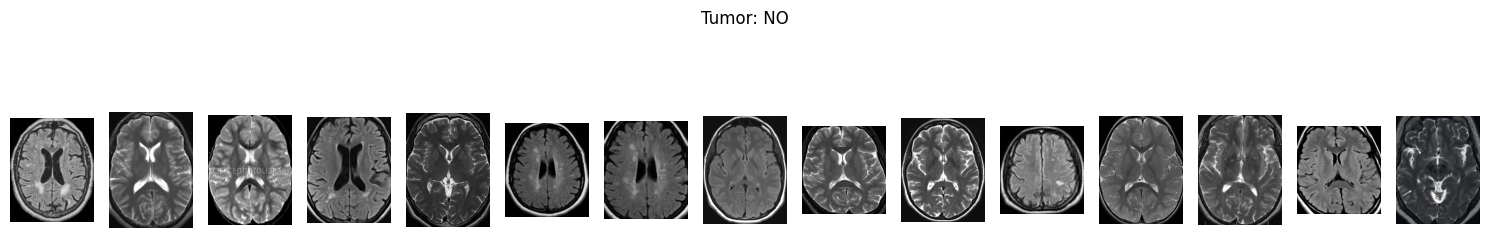

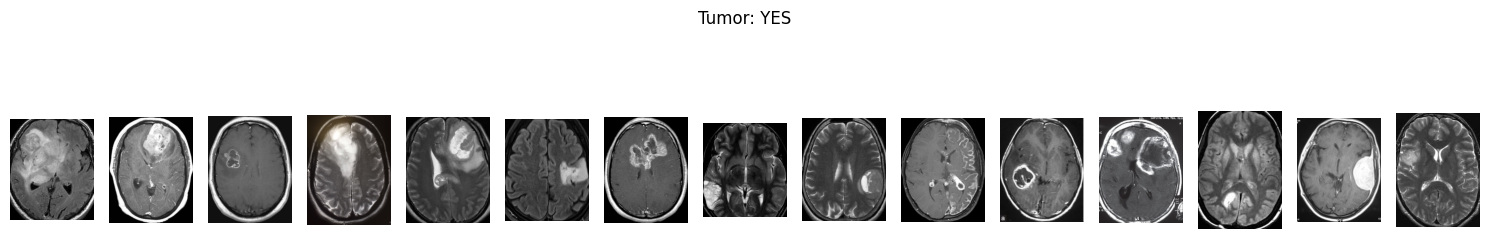

In [116]:
# Visualización después del recorte
plot_samples_class(X_train_crop, y_train, labels, 0)
plot_samples_class(X_train_crop, y_train, labels, 1)

### 4.3 - Alamcenamiento de las imágenes recortadas

In [117]:
def save_new_images(x_set, y_set, folder_name):
    """
    Guarda las imágenes en carpetas separadas según su clase (NO o YES)
    """
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        path = folder_name + ('NO/' if imclass == 0 else 'YES/')
        cv2.imwrite(path + str(i) + '.jpg', img)
        i += 1

In [118]:
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

In [119]:
save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

### 4.4 - Ejemplo de visualización con data augmentation

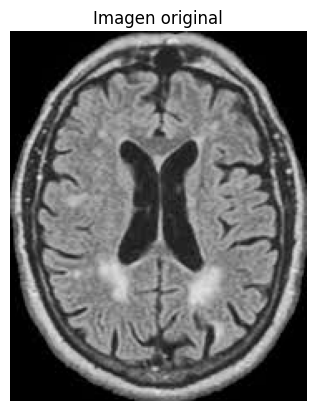

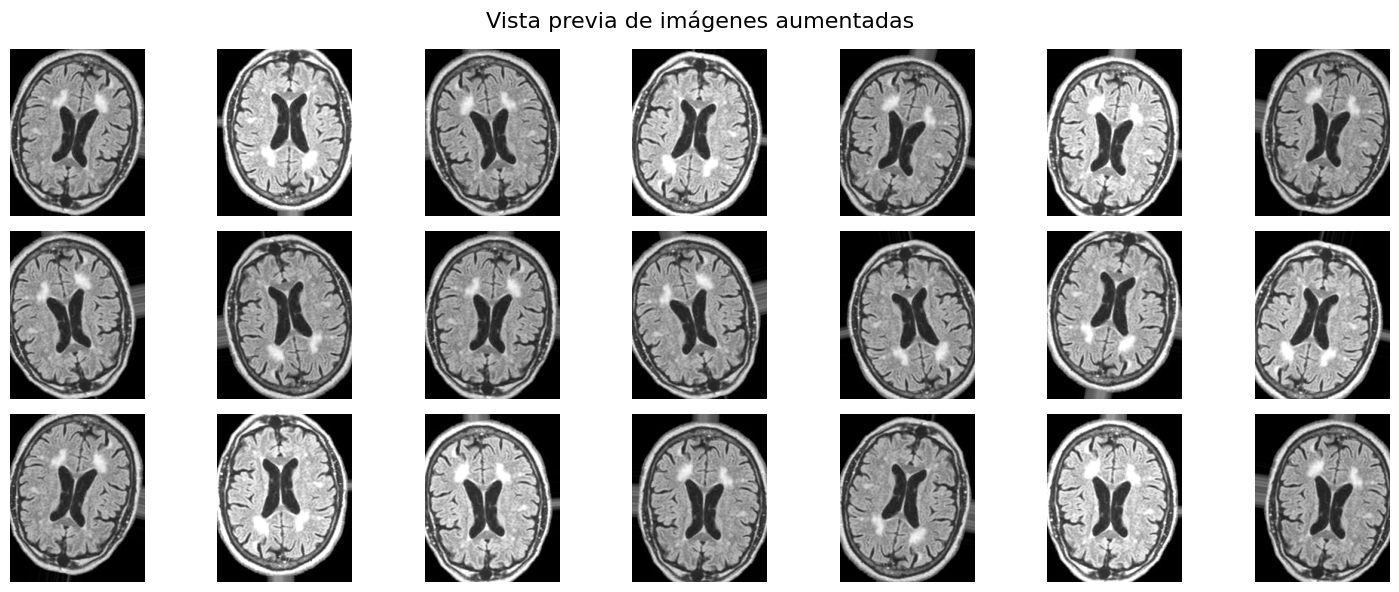

In [120]:
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

x = X_train_crop[0]
x = x.reshape((1,) + x.shape)

# Imagen original
plt.imshow(cv2.cvtColor(X_train_crop[0], cv2.COLOR_BGR2RGB))
plt.title("Imagen original")
plt.axis("off")
plt.show()

# Imágenes aumentadas
plt.figure(figsize=(15, 6))
i = 0

for batch in demo_datagen.flow(x, batch_size=1):
    img = array_to_img(batch[0])
    plt.subplot(3, 7, i + 1)
    plt.imshow(img)
    plt.axis('off')
    i += 1
    if i >= 21:
        break

plt.suptitle("Vista previa de imágenes aumentadas", fontsize=16)
plt.tight_layout()
plt.show()

## 5 - Entrenamiento de modelos

### 5.1 - Funciones auxiliares para entrenamiento y evaluación de modelos

In [121]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Matriz de Confusión', cmap=plt.cm.Blues):
    """
    Muestra la matriz de confusión como imagen, opcionalmente normalizada
    """
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    cm = np.round(cm, 2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Etiqueta real')
    plt.xlabel('Etiqueta predicha')
    plt.show()

In [122]:
def plot_training_history(history, name):
    """
    Muestra la evolución de la precisión y la pérdida durante el entrenamiento y la validación
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(history.epoch) + 1)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Entrenamiento')
    plt.plot(epochs_range, val_acc, label='Validación')
    plt.legend(loc="best")
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.title(f'{name} - Precisión')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Entrenamiento')
    plt.plot(epochs_range, val_loss, label='Validación')
    plt.legend(loc="best")
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.title(f'{name} - Pérdida')

    plt.tight_layout()
    plt.show()

In [123]:
def create_generators(preprocess_func):
    """
    Crea y devuelve los generadores de imágenes para entrenamiento y validación,
    aplicando aumentación de datos y el preprocesamiento correspondiente
    """

    train_datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        brightness_range=[0.5, 1.5],
        horizontal_flip=True,
        vertical_flip=True,
        preprocessing_function=preprocess_func
    )

    val_datagen = ImageDataGenerator(preprocessing_function=preprocess_func)

    train_generator = train_datagen.flow_from_directory(
        'TRAIN_CROP/', color_mode='rgb', target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary',
        seed=RANDOM_SEED
    )

    validation_generator = val_datagen.flow_from_directory(
        'VAL_CROP/', color_mode='rgb', target_size=IMG_SIZE, batch_size=VAL_BATCH_SIZE, class_mode='binary',
        seed=RANDOM_SEED
    )

    return train_generator, validation_generator

In [124]:
def evaluate_model(model, preprocess_func, name):
    """
    Evalúa el modelo sobre los conjuntos de validación y test.
    Imprime métricas de rendimiento, muestra ambas matrices de confusión,
    classification report y la curva ROC con el AUC
    """
    # Preprocesar validación y test
    X_val_prep = np.array([preprocess_func(cv2.resize(img, IMG_SIZE)) for img in X_val_crop])
    X_test_prep = np.array([preprocess_func(cv2.resize(img, IMG_SIZE)) for img in X_test_crop])

    # Predicciones
    y_val_probs = model.predict(X_val_prep).flatten()
    y_val_preds = (y_val_probs > 0.5).astype(int)

    y_test_probs = model.predict(X_test_prep).flatten()
    y_test_preds = (y_test_probs > 0.5).astype(int)

    # Accuracy
    val_acc = accuracy_score(y_val, y_val_preds)
    test_acc = accuracy_score(y_test, y_test_preds)
    print(f'Precisión en validación ({name}): {val_acc:.2f}')
    print(f'Precisión en test ({name}): {test_acc:.2f}')

    model_accuracies.append(
        {"Modelo": name, "Precisión Validación": round(val_acc, 4), "Precisión Test": round(test_acc, 4)})

    # Matrices de confusión lado a lado
    cm_val = confusion_matrix(y_val, y_val_preds)
    cm_test = confusion_matrix(y_test, y_test_preds)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    for ax, cm, title in zip(
            axes,
            [cm_val, cm_test],
            [f'{name} - Matriz de Confusión (Validación)', f'{name} - Matriz de Confusión (Test)']
    ):
        im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        ax.set_title(title)
        tick_marks = np.arange(len(labels))
        ax.set_xticks(tick_marks)
        ax.set_yticks(tick_marks)
        ax.set_xticklabels([labels[0], labels[1]])
        ax.set_yticklabels([labels[0], labels[1]])
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            ax.text(j, i, cm[i, j], ha="center", color="white" if cm[i, j] > thresh else "black")
        ax.set_ylabel('Etiqueta real')
        ax.set_xlabel('Etiqueta predicha')

    fig.tight_layout()
    plt.colorbar(im, ax=axes.ravel().tolist())
    plt.show()

    # ROC y AUC (solo validación)
    fpr, tpr, _ = roc_curve(y_val, y_val_probs)
    roc_auc = auc(fpr, tpr)
    print(f"AUC ({name}): {roc_auc:.4f}")

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('Tasa de falsos positivos')
    plt.ylabel('Tasa de verdaderos positivos')
    plt.title(f'{name} - Curva ROC (Validación)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    # Classification Report (solo validación)
    print(f"\nInforme de Clasificación ({name} - Validación):")
    print(classification_report(y_val, y_val_preds, target_names=[labels[0], labels[1]]))

In [125]:
def train_model(model, preprocess_func, callbacks, epochs):
    """
    Entrena el modelo y devuelve el historial de entrenamiento
    """
    train_generator, validation_generator = create_generators(preprocess_func)

    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        callbacks=callbacks
    )

    return history

### 5.2 - Modelo VGG16

In [126]:
# Definición y compilación del modelo VGG16
with strategy.scope():
    vgg_model = Sequential(name="VGG16")
    vgg_model.add(VGG16(weights="imagenet", include_top=False, input_shape=IMG_SIZE + (3,)))
    vgg_model.layers[0].trainable = False
    vgg_model.add(layers.Flatten())
    vgg_model.add(layers.Dropout(0.5))
    vgg_model.add(layers.Dense(1, activation='sigmoid'))

    vgg_model.compile(
        loss='binary_crossentropy',
        optimizer=RMSprop(learning_rate=1e-4),
        metrics=['accuracy']
    )

# Entrenar y guardar historial
history_vgg = train_model(
    vgg_model,
    vgg_preprocess,
    callbacks=[early_stop, reduce_lr],
    epochs=EPOCHS
)

Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 480ms/step - accuracy: 0.5399 - loss: 6.0809 - val_accuracy: 0.6400 - val_loss: 3.3560 - learning_rate: 1.0000e-04
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - accuracy: 0.5429 - loss: 5.1483 - val_accuracy: 0.6600 - val_loss: 3.0833 - learning_rate: 1.0000e-04
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step - accuracy: 0.6107 - loss: 4.1834 - val_accuracy: 0.6800 - val_loss: 2.9721 - learning_rate: 1.0000e-04
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step - accuracy: 0.5885 - loss: 3.8544 - val_accuracy: 0.7000 - val_loss: 2.8669 - learning_rate: 1.0000e-04
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 180ms/step - accuracy: 0.7311 - loss: 2.6925 - val_accuracy: 0.7000 - val_loss: 2.8211 - learning_rate: 1.0000e-04
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - accuracy: 0.6194 - loss: 3.5725 - val_accuracy: 0.7000 - val_loss: 2.7557 - learning_rate: 

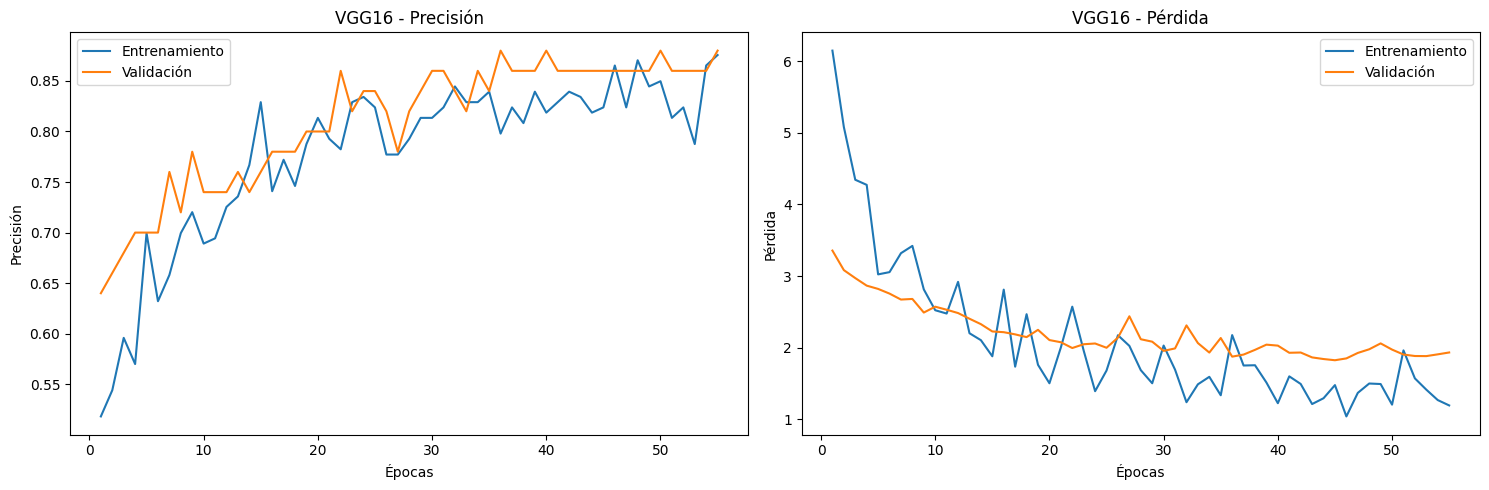

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
Precisión en validación (VGG16): 0.88
Precisión en test (VGG16): 0.60


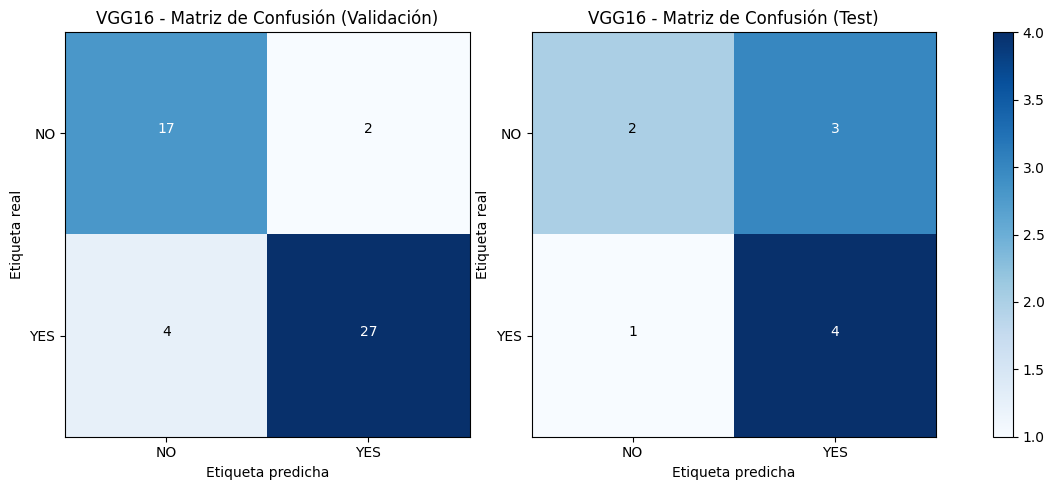

AUC (VGG16): 0.9202


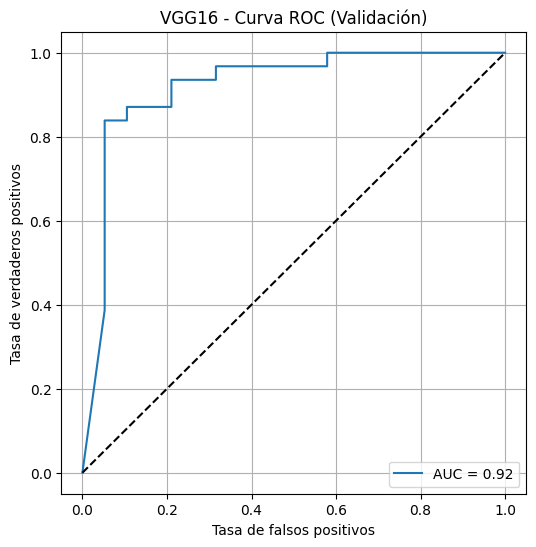


Informe de Clasificación (VGG16 - Validación):
              precision    recall  f1-score   support

          NO       0.81      0.89      0.85        19
         YES       0.93      0.87      0.90        31

    accuracy                           0.88        50
   macro avg       0.87      0.88      0.88        50
weighted avg       0.88      0.88      0.88        50



In [127]:
# Resultados de VGG16
plot_training_history(history_vgg, "VGG16")
evaluate_model(vgg_model, vgg_preprocess, "VGG16")

### 5.3 - Modelo ResNet50

In [128]:
# Definición y compilación del modelo ResNet50
with strategy.scope():
    resnet_model = Sequential(name="ResNet50")
    resnet_model.add(ResNet50(weights="imagenet", include_top=False, input_shape=IMG_SIZE + (3,)))
    resnet_model.layers[0].trainable = False
    resnet_model.add(layers.Flatten())
    resnet_model.add(layers.Dropout(0.5))
    resnet_model.add(layers.Dense(1, activation='sigmoid'))

    resnet_model.compile(
        loss='binary_crossentropy',
        optimizer=RMSprop(learning_rate=1e-4),
        metrics=['accuracy']
    )

# Entrenar y guardar historial
history_resnet = train_model(
    resnet_model,
    resnet_preprocess,
    callbacks=[early_stop, reduce_lr],
    epochs=EPOCHS
)

Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5198 - loss: 1.4629 - val_accuracy: 0.6600 - val_loss: 0.8476 - learning_rate: 1.0000e-04
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.7037 - loss: 1.0533 - val_accuracy: 0.7600 - val_loss: 0.6498 - learning_rate: 1.0000e-04
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.7063 - loss: 0.8964 - val_accuracy: 0.8000 - val_loss: 0.5510 - learning_rate: 1.0000e-04
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.8104 - loss: 0.6106 - val_accuracy: 0.7800 - val_loss: 0.6019 - learning_rate: 1.0000e-04
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.8082 - loss: 0.6069 - val_accuracy: 0.7800 - val_loss: 0.6403 - learning_rate: 1.0000e-04
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.8321 - loss: 0.5678 - val_accuracy: 0.7800 - val_loss: 0.5697 - learning_rate: 1.

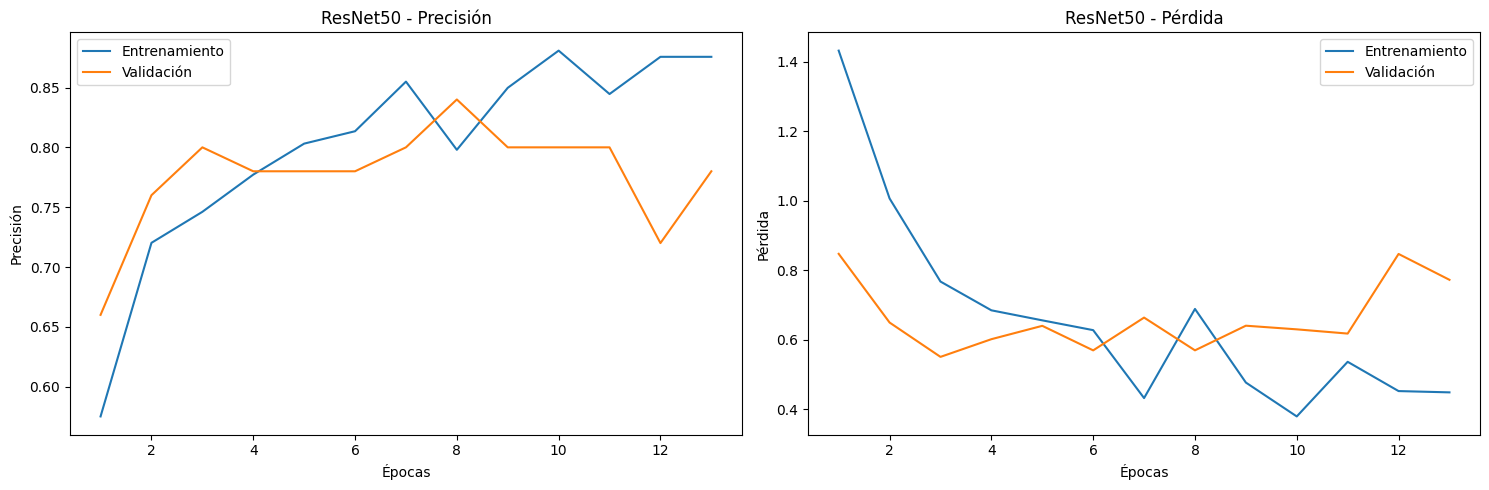

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step
Precisión en validación (ResNet50): 0.78
Precisión en test (ResNet50): 0.80


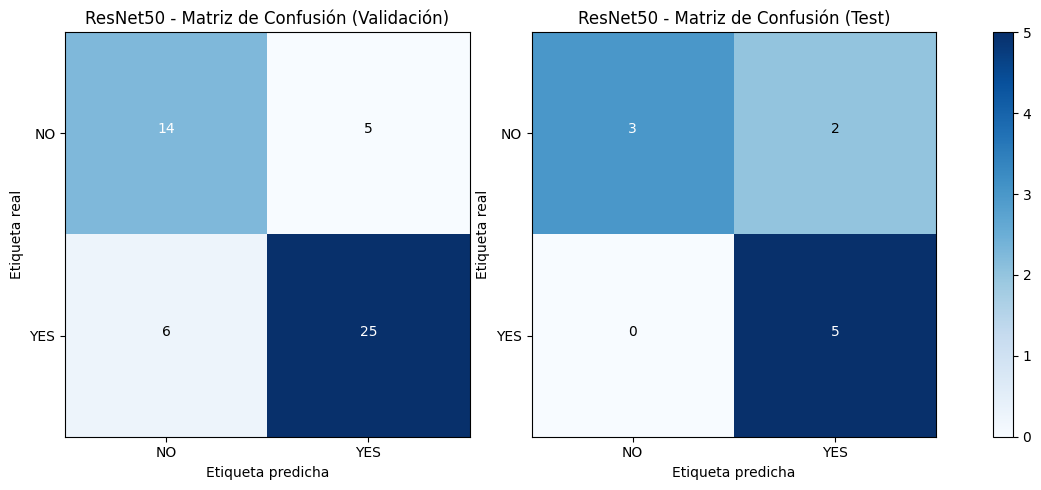

AUC (ResNet50): 0.8421


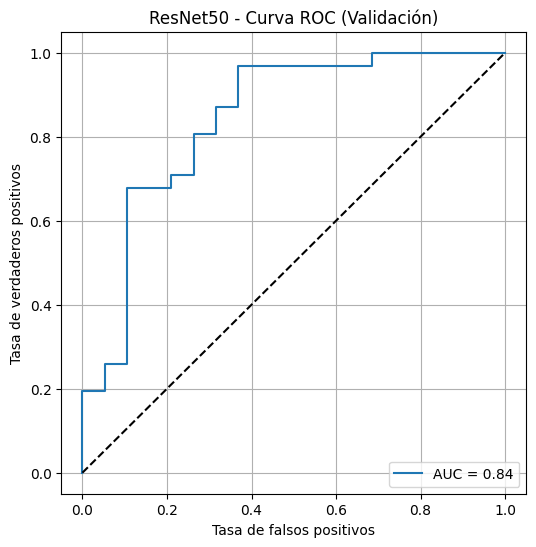


Informe de Clasificación (ResNet50 - Validación):
              precision    recall  f1-score   support

          NO       0.70      0.74      0.72        19
         YES       0.83      0.81      0.82        31

    accuracy                           0.78        50
   macro avg       0.77      0.77      0.77        50
weighted avg       0.78      0.78      0.78        50



In [129]:
# Resultados de ResNet50
plot_training_history(history_resnet, "ResNet50")
evaluate_model(resnet_model, resnet_preprocess, "ResNet50")

### 5.4 - Modelo MobileNetV2

In [130]:
# Definición y compilación del modelo MobileNetV2
with strategy.scope():
    mobilenet_model = Sequential(name="MobileNetV2")
    mobilenet_model.add(MobileNetV2(weights="imagenet", include_top=False, input_shape=IMG_SIZE + (3,)))
    mobilenet_model.layers[0].trainable = False
    mobilenet_model.add(layers.Flatten())
    mobilenet_model.add(layers.Dropout(0.5))
    mobilenet_model.add(layers.Dense(1, activation='sigmoid'))

    mobilenet_model.compile(
        loss='binary_crossentropy',
        optimizer=RMSprop(learning_rate=1e-4),
        metrics=['accuracy']
    )

# Entrenar y guardar historial
history_mobilenet = train_model(
    mobilenet_model,
    mobilenet_preprocess,
    callbacks=[early_stop, reduce_lr],
    epochs=EPOCHS
)

Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 931ms/step - accuracy: 0.5134 - loss: 1.3765 - val_accuracy: 0.6800 - val_loss: 0.4812 - learning_rate: 1.0000e-04
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.7008 - loss: 0.8284 - val_accuracy: 0.7000 - val_loss: 0.7985 - learning_rate: 1.0000e-04
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.7233 - loss: 0.7204 - val_accuracy: 0.8200 - val_loss: 0.5057 - learning_rate: 1.0000e-04
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.7604 - loss: 0.6132 - val_accuracy: 0.7800 - val_loss: 0.4165 - learning_rate: 1.0000e-04
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.7687 - loss: 0.5777 - val_accuracy: 0.7800 - val_loss: 0.4117 - learning_rate: 1.0000e-04
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.8405 - loss: 0.3623 - val_accuracy: 0.8600 - val_loss: 0.4532 - learning_rate: 1.00

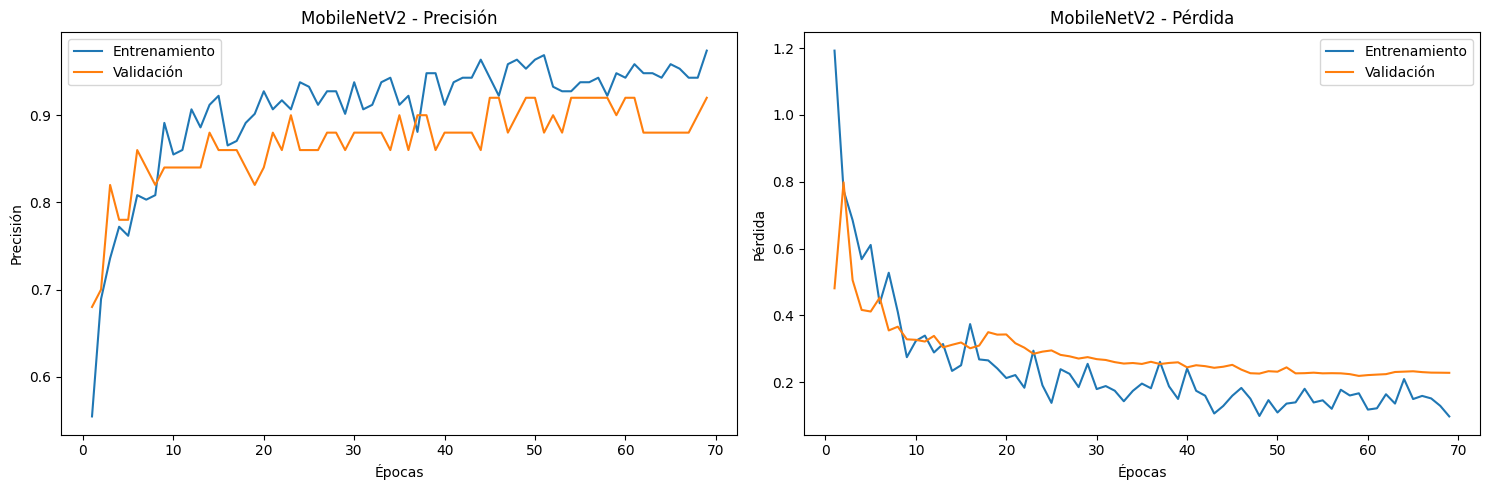

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Precisión en validación (MobileNetV2): 0.90
Precisión en test (MobileNetV2): 0.70


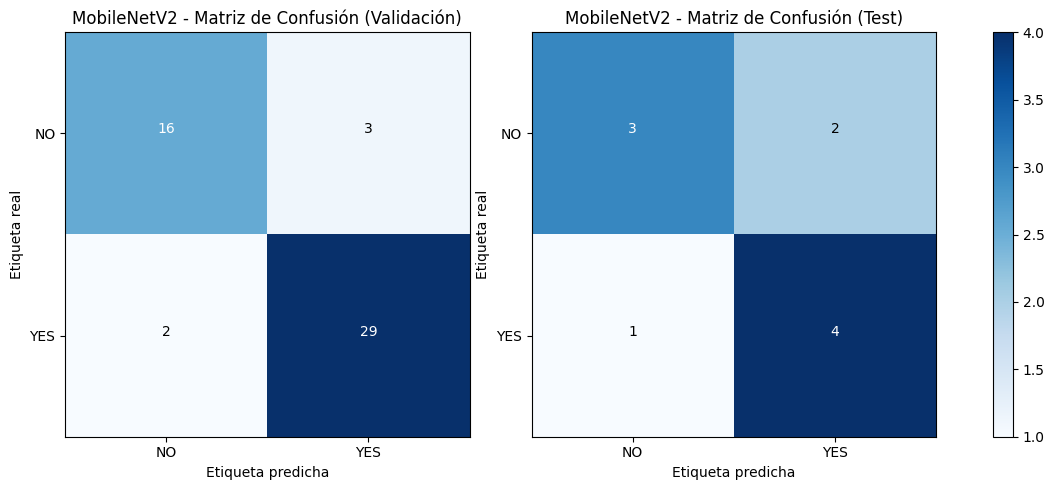

AUC (MobileNetV2): 0.9694


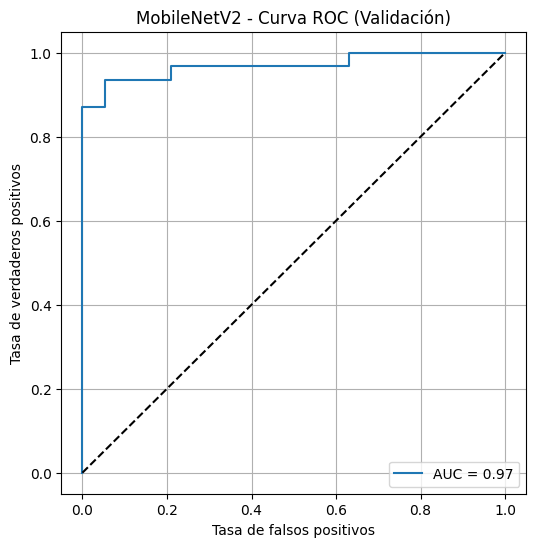


Informe de Clasificación (MobileNetV2 - Validación):
              precision    recall  f1-score   support

          NO       0.89      0.84      0.86        19
         YES       0.91      0.94      0.92        31

    accuracy                           0.90        50
   macro avg       0.90      0.89      0.89        50
weighted avg       0.90      0.90      0.90        50



In [131]:
# Resultados de MobileNetV2
plot_training_history(history_mobilenet, "MobileNetV2")
evaluate_model(mobilenet_model, mobilenet_preprocess, "MobileNetV2")

## 6 - Comparativa de los modelos

In [133]:
results_df = pd.DataFrame(model_accuracies)
results_df_sorted = results_df.sort_values(by="Precisión Validación", ascending=False)
display(results_df_sorted)

,Modelo,Precisión Validación,Precisión Test
2,MobileNetV2,0.90,0.7
0,VGG16,0.88,0.6
1,ResNet50,0.78,0.8


In [ ]:
# De los tres modelos evaluados, MobileNetV2 obtiene el mejor rendimiento en el conjunto de validación (90%) y un buen AUC (~0.97), aunque en test su precisión baja al 70%

# ResNet50 es el que mejor generaliza, con una precisión de ~80% para test y validación

# VGG16 muestra signos de overfitting. Alcanza un 88% en validación pero cae al 60% en test